In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, time

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import MetaData, Table, select

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
session = Session(engine)
connection = engine.connect()
print(engine.table_names())

['measurement', 'station']


In [6]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
#Get the table information
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Show the column information for measurement table
m_col = inspector.get_columns('measurement')
for c in m_col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Show the column information for the station table
s_col = inspector.get_columns('station')
for c in s_col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [10]:
def year_ago(date_str):
    new_date = datetime.strftime((datetime.strptime(date_str,'%Y-%m-%d') - dt.timedelta(days=365)).date(),'%Y-%m-%d')
    return new_date

In [11]:
year_ago('2018-06-24')

'2017-06-24'

In [12]:
from sqlalchemy.orm import aliased
from sqlalchemy import desc

# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
sel = [Measurement.date]
result = session.query(*sel).order_by(Measurement.date.desc()).first()
last_date = result[0]
last_date

'2017-08-23'

In [13]:
start_date = year_ago(last_date)
start_date

'2016-08-23'

In [14]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       Measurement.prcp]
precip = session.query(*sel).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).\
order_by(Measurement.date).all()

In [205]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip, columns=['date','precipitation'])
df.sort_values('date')
# Sort the dataframe by date
df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


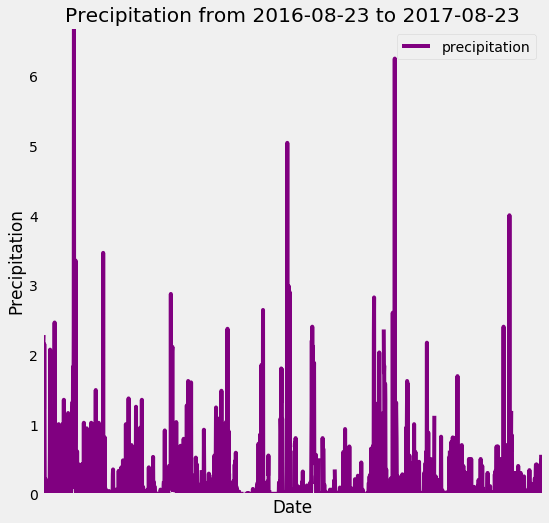

In [206]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(8,8), color='purple',grid=False)

plt.ylimit=(0,8)
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.autoscale(enable=True, axis='both', tight=True)
plt.title(f"Precipitation from {start_date} to {last_date}")
plt.savefig('./Images/precipitation.png')

In [207]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(f'Precipitation summary for the period {start_date} to {last_date}')
df.describe()

Precipitation summary for the period 2016-08-23 to 2017-08-23


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [208]:
# Design a query to show how many stations are available in this dataset?

result = session.query(func.count(Station.name)).distinct()
for item in result:
    print(f'There are {item[0]} stations available in this dataset.')

There are 9 stations available in this dataset.


In [209]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

results = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

for item in results:
    print(item)

most_active_station = results[0][0]
print(f'The most active station is {most_active_station}')

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active station is USC00519281


In [221]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),]
temp_data = session.query(*sel).\
    filter(Measurement.station == most_active_station).all()

print(f'The lowest temperature recorded was {temp_data[0][0]}°F, \
maximum {temp_data[0][1]}°F, average {round(temp_data[0][2],1)}°F for station {most_active_station}.')

The lowest temperature recorded was 54.0°F, maximum 85.0°F, average 71.7°F for station USC00519281.


In [222]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date,Measurement.tobs]
temps = session.query(*sel).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) > start_date).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.tobs).all()
temps

df = pd.DataFrame(temps, columns=['date','temperature'])
# Sort the dataframe by date
df.sort_values('date')
df.head()

,date,temperature
0,2017-02-02,59.0
1,2017-02-08,59.0
2,2017-02-09,59.0
3,2017-02-03,60.0
4,2017-04-30,60.0


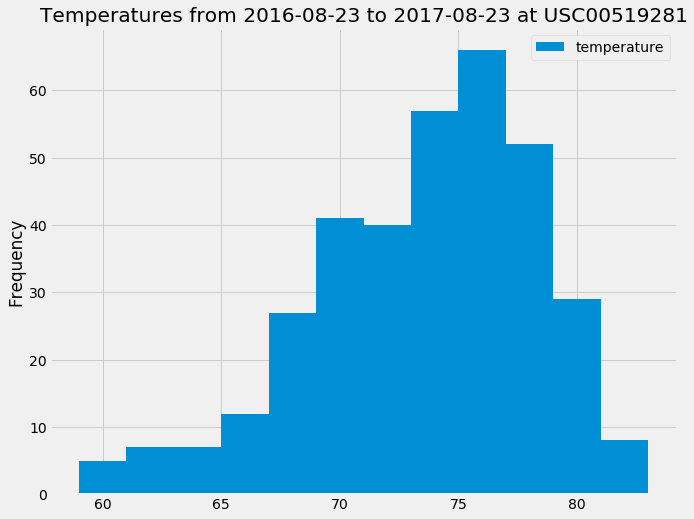

In [223]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot.hist(bins=12, figsize=(10,8))
plt.title(f"Temperatures from {start_date} to {last_date} at {most_active_station}")
plt.savefig('./Images/temperature_hist.png')

In [224]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [225]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = year_ago('2018-06-10')
trip_end_date = year_ago('2018-06-24')
trip_end_date

'2017-06-24'

In [226]:
trip_start_date

'2017-06-10'

In [227]:
prev_year = calc_temps(trip_start_date, trip_end_date)
tmin = prev_year[0][0]
tavg = round(prev_year[0][1],2)
tmax = prev_year[0][2]
tdif = tmax-tmin
print(f"The minimum temperature in your holiday period for the previous year was {tmin},\
 maximum {tmax} and average {tavg}. That's a swing of {tdif} degrees!")

The minimum temperature in your holiday period for the previous year was 71.0, maximum 83.0 and average 76.81. That's a swing of 12.0 degrees!


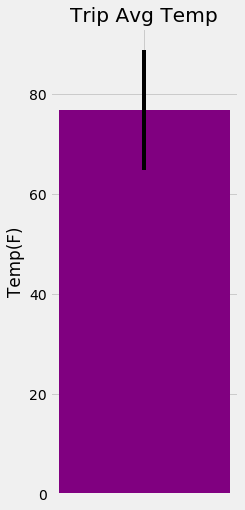

In [228]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,8)) 
plt.bar(x='',height=tavg, yerr=tdif, color='purple')
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.savefig('./Images/trip_temp.png')
plt.show()

In [229]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [func.sum(Measurement.prcp).label('precip'),
       Station.station,
      Station.name,
      Station.latitude,
      Station.longitude,
      Station.elevation]
precip = session.query(*sel).\
filter(Measurement.station==Station.station).\
filter(func.strftime("%Y-%m-%d", Measurement.date) > trip_start_date).\
filter(func.strftime("%Y-%m-%d", Measurement.date) < trip_end_date).\
group_by(Station.station).\
order_by(desc('precip')).all()

dfp = pd.DataFrame(precip)
dfp

,precip,station,name,latitude,longitude,elevation
0,7.35,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,2.81,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,2.07,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,1.68,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,0.54,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.17,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [230]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [231]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2019-02-01'
end_date = '2019-02-22'
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_len = (datetime.strptime(end_date,'%Y-%m-%d') - datetime.strptime(start_date,'%Y-%m-%d')).days + 1
trip_data = []
trip_dates = []
for date in range(0,trip_len):
    day = (datetime.strptime(start_date,'%Y-%m-%d') + dt.timedelta(days=date))
    trip_dates.append(datetime.strftime(day,'%m-%d'))
    trip_data.append(daily_normals(datetime.strftime(day,'%m-%d'))[0])


In [232]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dft = pd.DataFrame(trip_data, columns=['Min Temp','Avg Temp','Max Temp'])
dft['Date'] = trip_dates
dft

,Min Temp,Avg Temp,Max Temp,Date
0,56.0,68.140351,78.0,02-01
1,59.0,68.859649,77.0,02-02
2,58.0,67.796610,77.0,02-03
3,61.0,68.140351,76.0,02-04
4,59.0,69.684211,80.0,02-05
5,58.0,70.389831,77.0,02-06
6,60.0,69.000000,77.0,02-07
7,56.0,66.754386,74.0,02-08
8,57.0,67.589286,75.0,02-09
9,56.0,68.416667,76.0,02-10


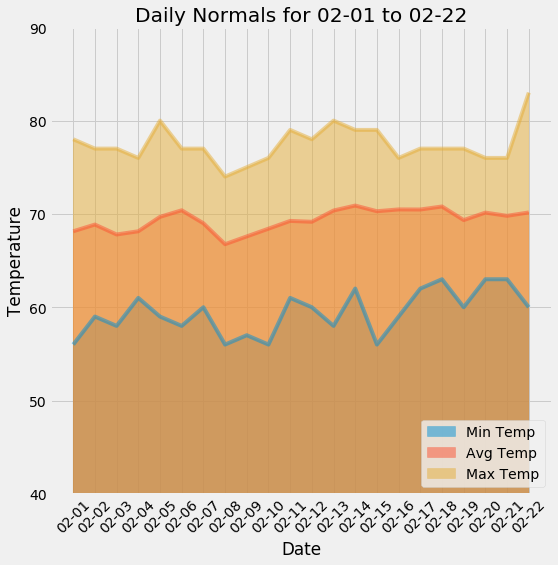

In [233]:
# Plot the daily normals as an area plot with `stacked=False`
ax = dft.plot(kind='area',stacked=False,figsize=(8,8),ylim=(40,90))
ax.set_xticks(range(len(dft)))
ax.set_xticklabels(dft['Date'], rotation=45)
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(loc='lower right')
plt.title(f"Daily Normals for {trip_dates[0]} to {trip_dates[21]}")
plt.savefig('./Images/daily_normals.png')